In [1]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.model import HGPforecaster
from libs.metrics import calculate_metrics, metrics_to_table
from libs.pre_processing import generate_groups_data
from libs.visual_analysis import visualize_fit, visualize_predict

import matplotlib.pyplot as plt
import pymc3 as pm
import numpy as np
import theano.tensor as tt
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

In [2]:
prison = pd.read_csv('../data/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['t'] = prison['t'].astype('datetime64[ns]')

In [3]:
prison_pivot = prison.pivot(index='t',columns=['state', 'gender', 'legal'], values='count')

In [4]:
groups_input = {
    'state': [0],
    'gender': [1],
    'legal': [2]
}

In [5]:
groups = generate_groups_data(prison_pivot, groups_input, seasonality=4, h=8)

Number of groups: 3
	state: 8
	gender: 2
	legal: 2
Total number of series: 32
Number of points per series for train: 40
Total number of points: 48
Seasonality: 4
Forecast horizon: 8


In [6]:
X = np.arange(groups['train']['n']).reshape(-1,1)
X_new = np.arange(groups['predict']['n']).reshape(-1,1)

In [390]:
p_s_fit = []
p_s_predict = []

for i in range(groups['train']['s']):    
    with pm.Model() as model:

        period = pm.Gamma('period', 40, 10)


        l_t = pm.InverseGamma('l_t', 4, 40, testval=7)
        l_p = pm.InverseGamma('l_p', 4, 40, testval=7)
        η_trend = pm.HalfNormal('η_trend',0.5, testval=0.5)
        η_per = pm.HalfNormal('η_per',0.5, testval=0.5)
        σ  = pm.HalfNormal("σ",  sigma=0.1, testval=0.1)

        a = pm.Normal('a', np.log(np.mean(groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,i])),0.1) 
        b = pm.Normal('b', mu=0, sd=0.1, testval=0.1)

        mu_func = pm.gp.mean.Linear(intercept = a,
                                   coeffs = b)


        # cov function for the GP 
        cov = (η_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t)
                + η_per * pm.gp.cov.Periodic(1, period=period, ls=l_p) 
                + pm.gp.cov.WhiteNoise(σ))

        gp = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
        f = gp.prior('f', X=X, reparameterize=True)

        y_pred = pm.Poisson('y_pred', mu=tt.exp(f), observed=groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,i])
        mp = pm.find_MAP(maxeval=5000, progressbar = False)
        
        pred_samples_fit = pm.sample_posterior_predictive([mp], 
                                      vars=[y_pred], 
                                      samples=200,
                                      progressbar=False)

        f_n = gp.conditional('f_n', Xnew=X_new)

        y_pred_new = pm.Poisson("y_pred_new", 
                                mu=tt.exp(f_n), 
                                shape=X_new.shape[0])

        pred_samples_predict = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred_new], 
                                                  samples=200,
                                                  progressbar = False)

    print(str(i)+'/'+str(groups['train']['s']-1))
    p_s_fit.append(pred_samples_fit['y_pred'])
    p_s_predict.append(pred_samples_predict['y_pred_new'])

0/31
1/31
2/31
3/31
4/31
5/31
6/31
7/31
8/31
9/31
10/31
11/31
12/31
13/31
14/31
15/31
16/31
17/31
18/31
19/31
20/31
21/31
22/31
23/31
24/31
25/31
26/31
27/31
28/31
29/31
30/31
31/31


In [391]:
p_s_fit = np.asarray(p_s_fit)
p_s_predict = np.asarray(p_s_predict)
p_s_fit = p_s_fit.transpose(1, 0, 2).reshape(200, 40*32)
p_s_predict = p_s_predict.transpose(1, 0, 2).reshape(200, 48*32)
p_s_fit_d = {}
p_s_predict_d = {}
p_s_fit_d['y_pred'] = p_s_fit
p_s_predict_d['y_pred_new'] = p_s_predict

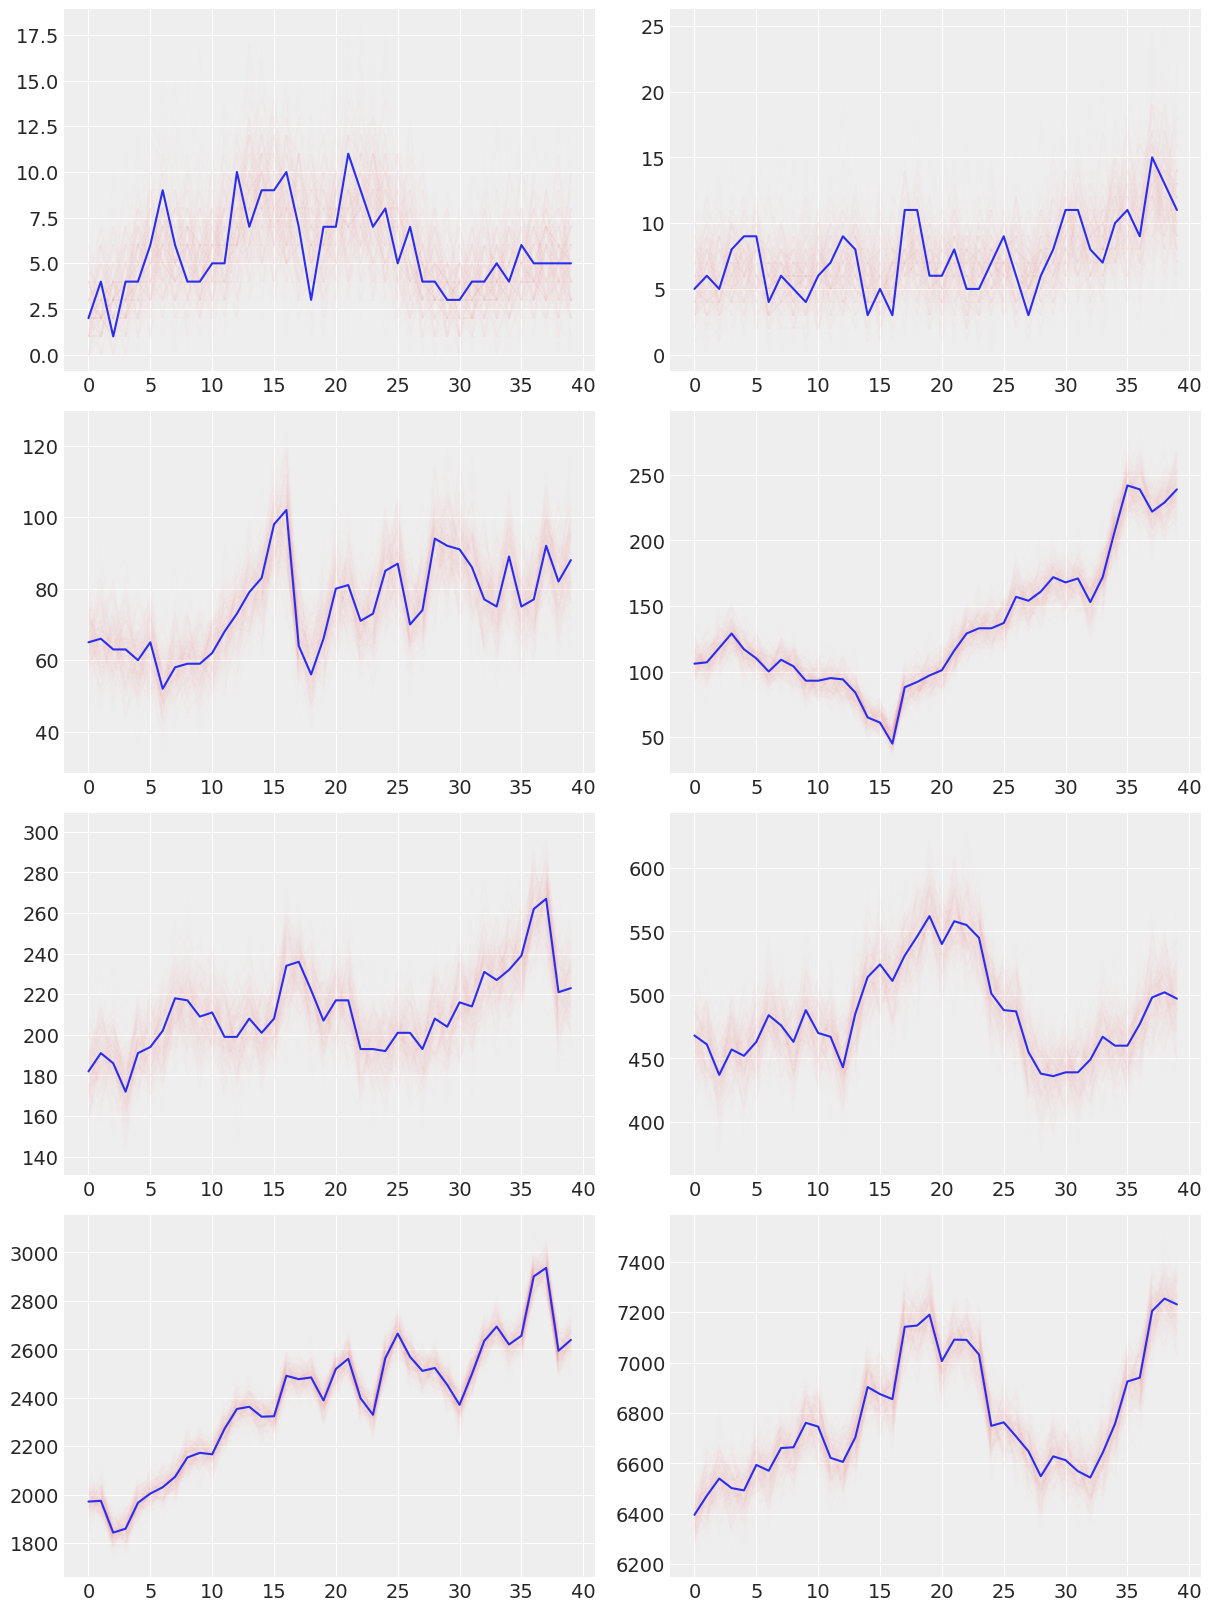

In [392]:
visualize_fit(groups, p_s_fit_d, 8)

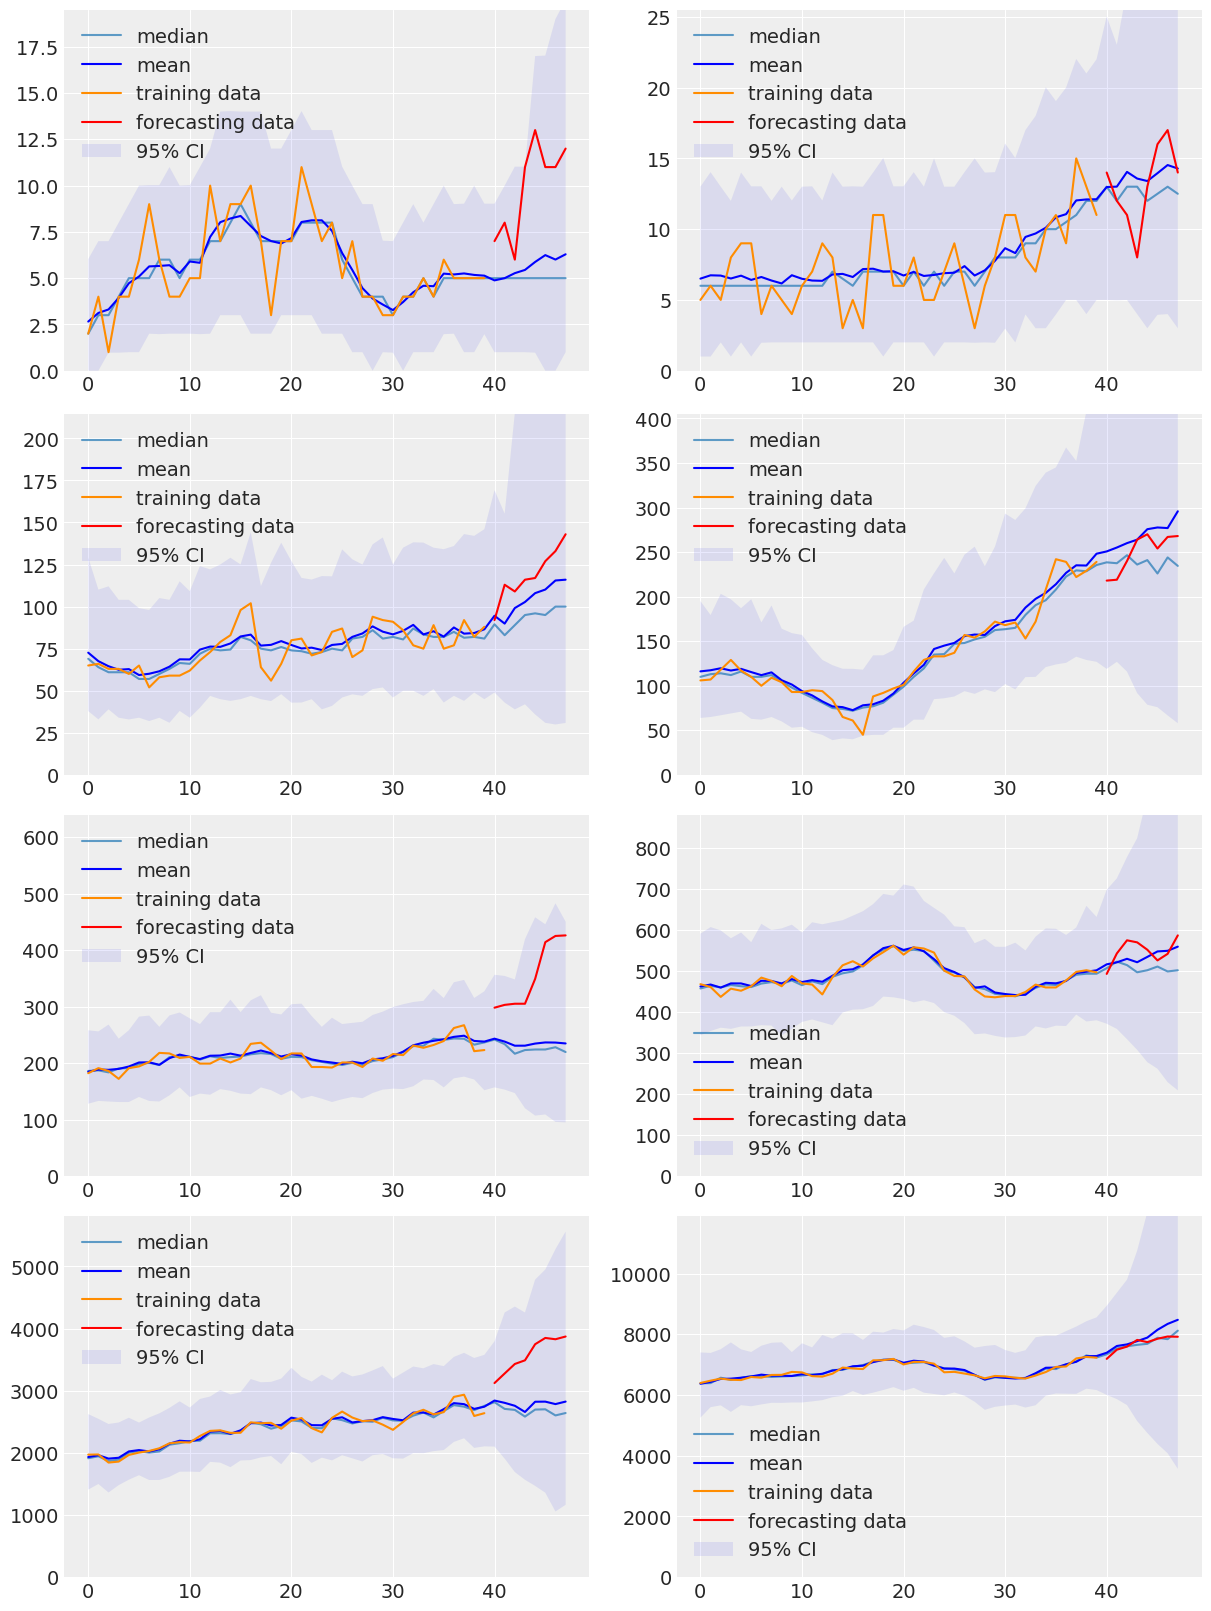

In [393]:
visualize_predict(groups, p_s_predict_d, 8)

In [394]:
results = calculate_metrics(p_s_predict_d, groups)
metrics_to_table(groups, results)

,bottom,total,state,gender,legal,all
mase,2.366,0.775,1.698,0.594,2.923,2.189
rmse,141.072,881.463,323.332,483.459,1821.58,223.338


# Test a single series

Prior selection for GPs: 
https://betanalpha.github.io/assets/case_studies/gaussian_processes.html

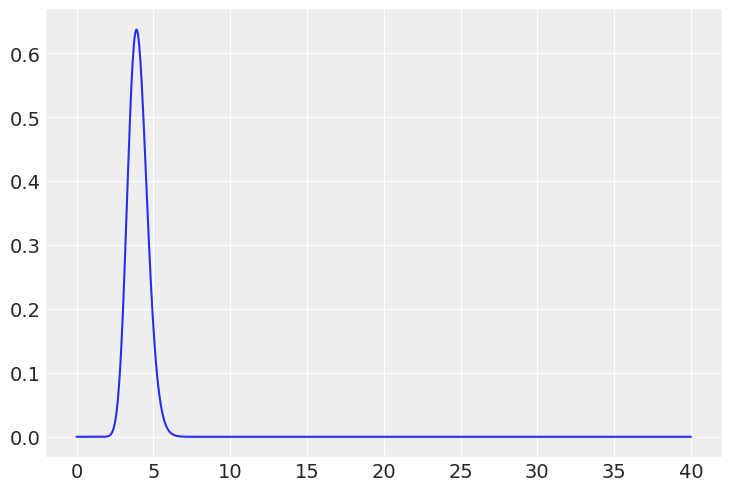

In [272]:
# prior for period parameter
x = np.linspace(0, 40, 1000)
plt.plot(x, np.exp(pm.Gamma.dist(40, 10).logp(x).eval()));

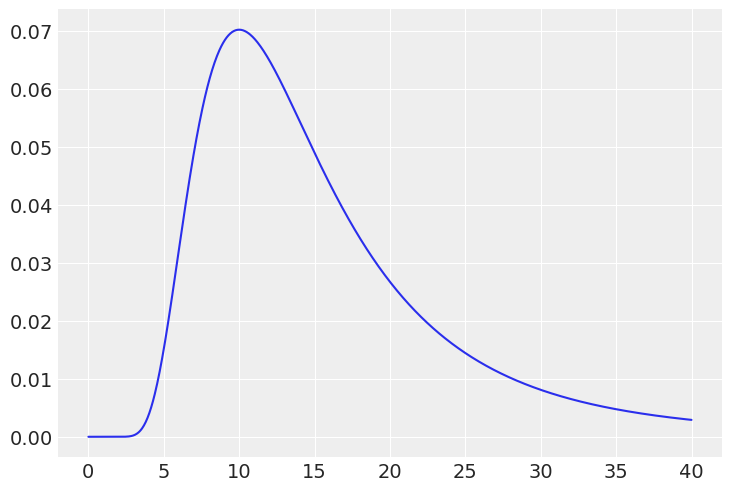

In [1188]:
# prior for lengthscale parameter
x = np.linspace(0, 40, 1000)
plt.plot(x, np.exp(pm.InverseGamma.dist(4, 40).logp(x).eval()));

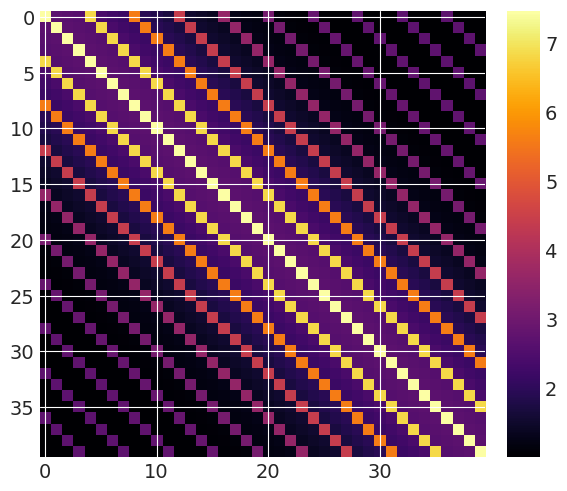

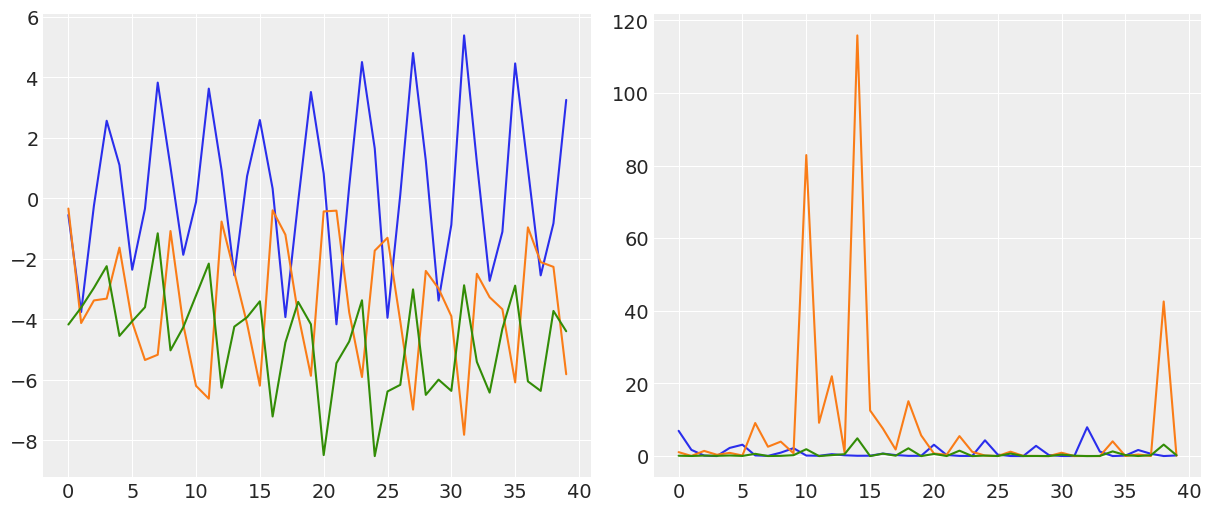

In [859]:
import theano


l_t = 10
l_p = 0.1
η_trend = 1
η_per = 1
σ  = 0.1

# cov function for the GP 
cov = (η_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t)
        + η_per * pm.gp.cov.Periodic(1, period=4, ls=l_p) 
        + pm.gp.cov.WhiteNoise(σ))

K = np.exp(cov(X).eval())
m = plt.imshow(K, cmap="inferno", interpolation="none")
plt.colorbar(m)
plt.show()
_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = ax.ravel()
ax[0].plot((pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K, shape=K.shape[0]).random(size=3).T))
ax[1].plot(np.exp(pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K, shape=K.shape[0]).random(size=3).T));

In [1137]:
from pymc3.gp.mean import Mean
class Linear(Mean):
    R"""
    Linear mean function for Gaussian process.
    Parameters
    ----------
    coeffs: variables
        Linear coefficients
    intercept: variable, array or integer
        Intercept for linear function (Defaults to zero)
    """

    def __init__(self, coeffs, intercept=0):
        Mean.__init__(self)
        self.b = intercept
        self.A = coeffs

    def __call__(self, X):
        return tt.squeeze(tt.dot(X, self.A) + self.b)

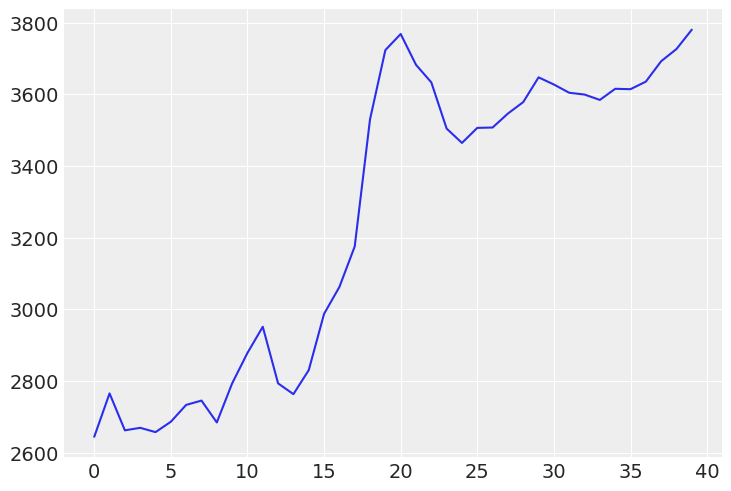

In [434]:
series = 31
plt.plot(groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,series]);

In [440]:
with pm.Model() as model:
    period = pm.Gamma('period', 40, 10)


    l_t = pm.InverseGamma('l_t', 4, 40, testval=7)
    l_p = pm.InverseGamma('l_p', 4, 40, testval=7)
    η_trend = pm.HalfNormal('η_trend',0.5, testval=0.5)
    η_per = pm.HalfNormal('η_per',0.5, testval=0.5)
    σ  = pm.HalfNormal("σ",  sigma=0.1, testval=0.1)

    a = pm.Normal('a', np.log(np.mean(groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,series])),0.1) 
    b = pm.Normal('b', mu=0, sd=0.1, testval=0.1)

    mu_func = pm.gp.mean.Linear(intercept = a,
                               coeffs = b)


    # cov function for the GP 
    cov = (η_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t)
            + η_per * pm.gp.cov.Periodic(1, period=period, ls=l_p) 
            + pm.gp.cov.WhiteNoise(σ))

    gp = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
    f = gp.prior('f', X=X, reparameterize=True)

    y_pred = pm.Poisson('y_pred', mu=tt.exp(f), observed=groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,series])
    mp = pm.find_MAP(maxeval=5000)

In [441]:
with model:
    sam = pm.sample_posterior_predictive(trace)

In [442]:
mp['a']

array(8.08573416)

In [443]:
mp

{'period_log__': array(1.36673925),
 'l_t_log__': array(1.77258765),
 'l_p_log__': array(2.19224802),
 'η_trend_log__': array(-1.23193529),
 'η_per_log__': array(-1.31284785),
 'σ_log__': array(-2.08006209),
 'a': array(8.08573416),
 'b': array(0.00642448),
 'f_rotated_': array([-0.27133702,  0.15048369, -0.21010556, -0.11156079, -0.11032184,
        -0.02473449,  0.05078197, -0.00737086, -0.20584472,  0.05500218,
         0.11204843,  0.10016954, -0.36300292, -0.30104353, -0.0262763 ,
         0.29638522,  0.24054349,  0.19453645,  0.48644405,  0.28514446,
        -0.04633783, -0.3878129 , -0.4004453 , -0.36436991, -0.07478679,
         0.19248867,  0.20081053,  0.24045633,  0.17980456,  0.09709492,
        -0.12845894, -0.18671148, -0.14333561, -0.13462825, -0.02116431,
         0.03659796,  0.08939375,  0.1040426 ,  0.04663675,  0.06147442]),
 'period': array(3.92253939),
 'l_t': array(5.88606478),
 'l_p': array(8.95532222),
 'η_trend': array(0.29172746),
 'η_per': array(0.26905274)

In [444]:
with pm.Model() as model:
    f_n0 = gp.conditional('f_n0', Xnew=X_new)

    y_pred_new0 = pm.Poisson("y_pred_new0", 
                            mu=tt.exp(f_n0), 
                            shape=X_new.shape[0])

    pred_samples0 = pm.sample_posterior_predictive([mp], 
                                              vars=[y_pred_new0], 
                                              samples=200,
                                              progressbar = False)

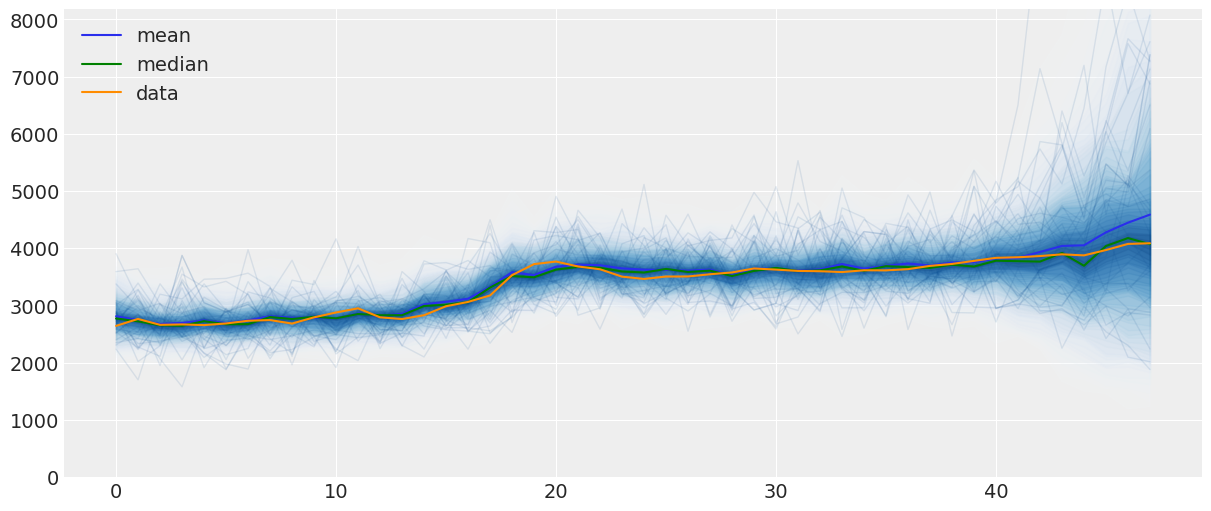

In [445]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples0['y_pred_new0'], X_new, palette="Blues", fill_alpha=0.1, samples_alpha=0.1);
plt.plot(np.mean(pred_samples0['y_pred_new0'], axis=0), label='mean')
plt.plot(np.median(pred_samples0['y_pred_new0'], axis=0), label='median', color='green')
plt.plot(np.arange(groups['predict']['n']),(groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T[:,series]), label='data', color='darkorange')
plt.ylim(0,max((groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T[:,series]))*2)
plt.legend();